In [ ]:
which hhblits

In [ ]:
pfam="/home/lucas/bin/hh-suite/databases/pfamA_35.0/pfam"
metadata="/mnt/DATA/School/2022-2023/Thesis/Scripting/Mining/PaePhageInfoRetrieval/ICTV_Metadata_raw.txt"
cds_db="/mnt/DATA/School/2022-2023/Thesis/Scripting/Mining/PaePhageInfoRetrieval/PaePhages_CDSs.fasta"

### Preprocessing

Splitting the multi-fasta

In [ ]:
rm -rf entries
mkdir entries
cd entries
grep '>' $cds_db | cut -d ' ' -f 1 | tr -d '>' > ../names
awk '/^>/{s=++d".fasta"} {print > s}' $cds_db

Renaming the separate fasta files to their entry name

In [ ]:
entryList=$(dir)
for entry in $entryList
do
number=$(basename "$entry" | grep -Eo "[0-9]+")
name=$(awk 'NR == n' n=$number ../names)
mv "$entry" "$name.fasta"
done
cd ..
rm names

In [ ]:
dir -1 ./entries | wc -l

### Standard analysis with one iteration
n = 1; e = 0.001; mact = 0.35

Including an if statement to resume from where the previous runtime was halted.

In [ ]:
results_prefix="results.n1"

In [ ]:
mkdir $results_prefix

In [ ]:
entryList=$(dir -1 ./entries)
fileNumber=$(echo "$entryList" | wc -l)
fileCount=0
for entry in $entryList
do
fileCount=$(($fileCount+1))
echo "Processing $entry ($fileCount/$fileNumber)"
if [ -f "./$results_prefix/$entry.hhr" ]
then
echo "Results file already present. Skipping..."
continue
fi
hhblits -i ./entries/$entry \
        -o ./$results_prefix/$entry.hhr \
        -d $pfam -n 1 \
        -cpu 4 -v 1
done
echo "DONE"

In [ ]:
dir -1 $results_prefix | wc -l

### Results processing

In [ ]:
query="NAT|Acetylt"

I think there are quite some false positives here. The first two records in this list have very low Prob (< 25) and high E-values (> 1). Need some better cut-offs or filtering here. DONE, made a combination of the two suggestions by the HHsuite team (Prob > 50 or (Prob > 30 and among top 3)).
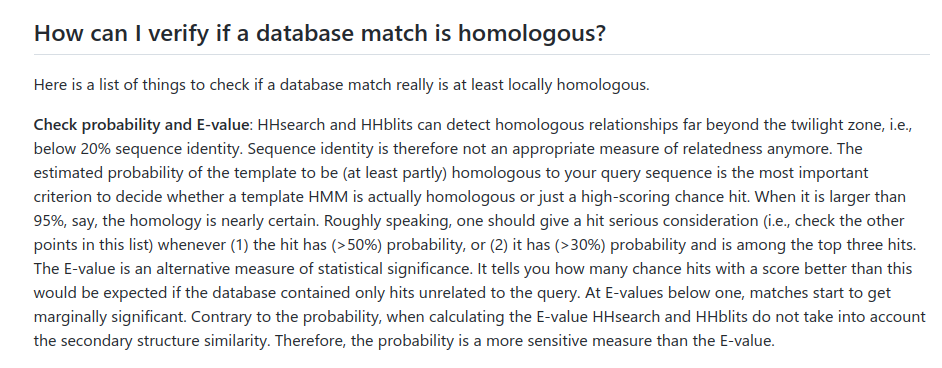

In [ ]:
counts_filename="counts.n1"

In [ ]:
cd $results_prefix
echo -e "# CDS\tNr of matches\tHighest match Prob\tPosition of top hit\tMatched HMMs" > ../$counts_filename
entries=$(dir -1)
for entry in $entries
do
    count=$(grep '>' $entry | grep -Ec $query)
    if [ $count -eq 0 ]
    then
        continue
    fi
    prob=$(grep -A 1 '>' $entry | grep -A 1 -E $query | grep -Eo 'Probab=[0-9]+' | grep -Eo '[0-9]+' | head -1)
    hitnr=$(grep -B 1 '>' $entry | grep -B 1 -E $query | head -1 | grep -Eo '[0-9]+')
    if [ $prob -lt 30 ]
    then
        continue
    fi
    if [ $hitnr -gt 3 ]
    then
        if [ $prob -lt 50 ]
        then
            continue
        fi
    fi
    matched=$(grep '>' $entry | grep -E $query | cut -d ';' -f 1 | tr -d '> ' | sort -u | head -c -1 | tr '\n' ',')
    echo -e "$entry\t$count\t$prob\t$hitnr\t$matched" >> ../$counts_filename
done
cd ..
cat $counts_filename

In [ ]:
wc -l $counts_filename

89 hits!

From now on, this processing method is used, as it can capture more hits with a criterion that is still reasonable.

**Assigning species**

In [ ]:
species=$(grep -v '#' $counts_filename | cut -f 1 | cut -d '.' -f 1 | cut -c 5-)
for s in $species
do
grep "$s" $metadata | cut -f 10 >> tmp
done
paste <(sort -u tmp) <(sort tmp | uniq -c | tr -s ' ' '\t' | cut -f 2) > $counts_filename.species
rm tmp
cat $counts_filename.species

### Standard analysis with three iterations

In [ ]:
results_prefix="results.n3"

In [ ]:
mkdir -p $results_prefix
entryList=$(dir -1 ./entries)
fileNumber=$(echo "$entryList" | wc -l)
fileCount=0
for entry in $entryList
do
fileCount=$(($fileCount+1))
echo "Processing $entry ($fileCount/$fileNumber)"
if [ -f "./$results_prefix/$entry.hhr" ]
then
echo "Results file already present. Skipping..."
continue
fi
hhblits -i ./entries/$entry \
        -o ./$results_prefix/$entry.hhr \
        -d $pfam -n 3 \
        -cpu 4 -v 1
done
echo "DONE"

In [ ]:
dir -1 $results_prefix | wc -l

**Results processing**

In [ ]:
counts_filename="counts.n3"

In [ ]:
cd $results_prefix
echo -e "# CDS\tNr of matches\tHighest match Prob\tPosition of top hit\tMatched HMMs" > ../$counts_filename
entries=$(dir -1)
for entry in $entries
do
    count=$(grep '>' $entry | grep -Ec $query)
    if [ $count -eq 0 ]
    then
        continue
    fi
    prob=$(grep -A 1 '>' $entry | grep -A 1 -E $query | grep -Eo 'Probab=[0-9]+' | grep -Eo '[0-9]+' | head -1)
    hitnr=$(grep -B 1 '>' $entry | grep -B 1 -E $query | head -1 | grep -Eo '[0-9]+')
    if [ $prob -lt 30 ]
    then
        continue
    fi
    if [ $hitnr -gt 3 ]
    then
        if [ $prob -lt 50 ]
        then
            continue
        fi
    fi
    matched=$(grep '>' $entry | grep -E $query | cut -d ';' -f 1 | tr -d '> ' | sort -u | head -c -1 | tr '\n' ',')
    echo -e "$entry\t$count\t$prob\t$hitnr\t$matched" >> ../$counts_filename
done
cd ..
cat $counts_filename

In [ ]:
wc -l $counts_filename

107 hits

**Assigning species**

In [ ]:
species=$(grep -v '#' $counts_filename | cut -f 1 | cut -d '.' -f 1 | cut -c 5-)
for s in $species
do
grep "$s" $metadata | cut -f 10 >> tmp
done
paste <(sort -u tmp) <(sort tmp | uniq -c | tr -s ' ' '\t' | cut -f 2) > $counts_filename.species
rm tmp
cat $counts_filename.species

### Sensitive analysis with decreased -mact (0.25) and three iterations

The mact parameter allows to tweak the sensitivity at the cost of precision. Default value is 0.35, so let's check out what happens when pushing it a little bit more sensitive.
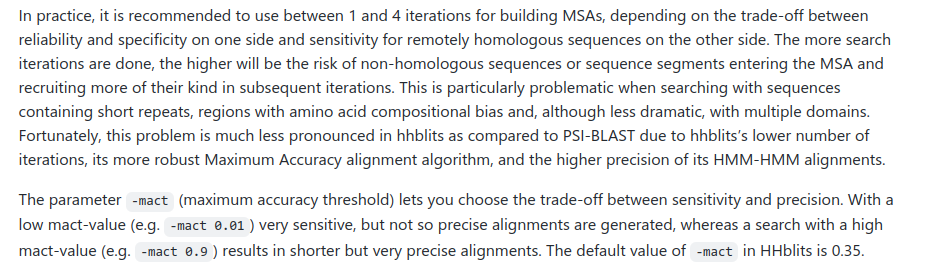

In [ ]:
results_prefix="results.n3.mact25"

In [ ]:
mkdir -p $results_prefix
entryList=$(dir -1 ./entries)
fileNumber=$(echo "$entryList" | wc -l)
fileCount=0
for entry in $entryList
do
fileCount=$(($fileCount+1))
echo "Processing $entry ($fileCount/$fileNumber)"
if [ -f "./$results_prefix/$entry.hhr" ]
then
echo "Results file already present. Skipping..."
continue
fi
hhblits -i ./entries/$entry \
        -o ./$results_prefix/$entry.hhr \
        -d $pfam -n 3 -mact 0.25 \
        -cpu 4 -v 1
done
echo "DONE"

In [ ]:
dir -1 $results_prefix | wc -l

**Results processing**

In [ ]:
counts_filename="counts.n3.mact25"

In [ ]:
cd $results_prefix
echo -e "# CDS\tNr of matches\tHighest match Prob\tPosition of top hit\tMatched HMMs" > ../$counts_filename
entries=$(dir -1)
for entry in $entries
do
    count=$(grep '>' $entry | grep -Ec $query)
    if [ $count -eq 0 ]
    then
        continue
    fi
    prob=$(grep -A 1 '>' $entry | grep -A 1 -E $query | grep -Eo 'Probab=[0-9]+' | grep -Eo '[0-9]+' | head -1)
    hitnr=$(grep -B 1 '>' $entry | grep -B 1 -E $query | head -1 | grep -Eo '[0-9]+')
    if [ $prob -lt 30 ]
    then
        continue
    fi
    if [ $hitnr -gt 3 ]
    then
        if [ $prob -lt 50 ]
        then
            continue
        fi
    fi
    matched=$(grep '>' $entry | grep -E $query | cut -d ';' -f 1 | tr -d '> ' | sort -u | head -c -1 | tr '\n' ',')
    echo -e "$entry\t$count\t$prob\t$hitnr\t$matched" >> ../$counts_filename
done
cd ..
cat $counts_filename

In [ ]:
wc -l $counts_filename

**Assigning species**

In [ ]:
species=$(grep -v '#' $counts_filename | cut -f 1 | cut -d '.' -f 1 | cut -c 5-)
for s in $species
do
grep "$s" $metadata | cut -f 10 >> tmp
done
paste <(sort -u tmp) <(sort tmp | uniq -c | tr -s ' ' '\t' | cut -f 2) > $counts_filename.species
rm tmp
cat $counts_filename.species

In [ ]:
comm counts.n3.mact25.species counts.n3.species

No new species, this is not a worthy approach.

### Standard analysis with max number of iterations

In [ ]:
results_prefix="results.nm"

In [ ]:
mkdir -p $results_prefix
entryList=$(dir -1 ./entries)
fileNumber=$(echo "$entryList" | wc -l)
fileCount=0
for entry in $entryList
do
fileCount=$(($fileCount+1))
echo "Processing $entry ($fileCount/$fileNumber)"
if [ -f "./$results_prefix/$entry.hhr" ]
then
echo "Results file already present. Skipping..."
continue
fi
hhblits -i ./entries/$entry \
        -o ./$results_prefix/$entry.hhr \
        -d $pfam -n 8 \
        -cpu 4 -v 1
done
echo "DONE"

In [ ]:
dir -1 $results_prefix | wc -l

**Results processing**

In [ ]:
counts_filename="counts.nm"

In [ ]:
cd $results_prefix
echo -e "# CDS\tNr of matches\tHighest match Prob\tPosition of top hit\tMatched HMMs" > ../$counts_filename
entries=$(dir -1)
for entry in $entries
do
    count=$(grep '>' $entry | grep -Ec $query)
    if [ $count -eq 0 ]
    then
        continue
    fi
    prob=$(grep -A 1 '>' $entry | grep -A 1 -E $query | grep -Eo 'Probab=[0-9]+' | grep -Eo '[0-9]+' | head -1)
    hitnr=$(grep -B 1 '>' $entry | grep -B 1 -E $query | head -1 | grep -Eo '[0-9]+')
    if [ $prob -lt 30 ]
    then
        continue
    fi
    if [ $hitnr -gt 3 ]
    then
        if [ $prob -lt 50 ]
        then
            continue
        fi
    fi
    matched=$(grep '>' $entry | grep -E $query | cut -d ';' -f 1 | tr -d '> ' | sort -u | head -c -1 | tr '\n' ',')
    echo -e "$entry\t$count\t$prob\t$hitnr\t$matched" >> ../$counts_filename
done
cd ..
cat $counts_filename

In [ ]:
wc -l $counts_filename

**Assigning species**

In [ ]:
species=$(grep -v '#' $counts_filename | cut -f 1 | cut -d '.' -f 1 | cut -c 5-)
for s in $species
do
grep "$s" $metadata | cut -f 10 >> tmp
done
paste <(sort -u tmp) <(sort tmp | uniq -c | tr -s ' ' '\t' | cut -f 2) > $counts_filename.species
rm tmp
cat $counts_filename.species

In [ ]:
comm counts.nm.species counts.n3.species

No new hits! Applying three iterations already captures everything